# Computer Vision: Understanding Image Embeddings and Clustering

Welcome to this tutorial on computer vision! In this notebook, we'll explore:

1. 📸 **Fashion MNIST Dataset** - A dataset of clothing images
2. 🧠 **DINO Model** - A state-of-the-art vision transformer for feature extraction
3. 🔢 **Image Embeddings** - How neural networks "understand" images
4. 🗺️ **UMAP** - A dimensionality reduction technique for visualization
5. 🎯 **Clustering** - Discovering similar images automatically
6. 📊 **Cluster Quality** - Evaluating how well items group together

By the end, you'll understand how AI models convert images into meaningful numerical representations and how similar items naturally cluster together!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModel
from umap import UMAP
from sklearn.decomposition import PCA
import random
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 📦 Loading the Fashion MNIST Dataset

Fashion MNIST is a dataset of 70,000 grayscale images of clothing items:
- **10 classes**: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
- **Image size**: 28x28 pixels
- **Training set**: 60,000 images
- **Test set**: 10,000 images

It's a more challenging alternative to the classic MNIST digit dataset and perfect for learning computer vision!

In [2]:
# Load Fashion MNIST from Hugging Face
print("Loading Fashion MNIST dataset...")
dataset = load_dataset("fashion_mnist")

# Get train and test splits
train_data = dataset['train']
test_data = dataset['test']

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nDataset features: {train_data.features}")

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Loading Fashion MNIST dataset...
Training samples: 60000
Test samples: 10000

Dataset features: {'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])}


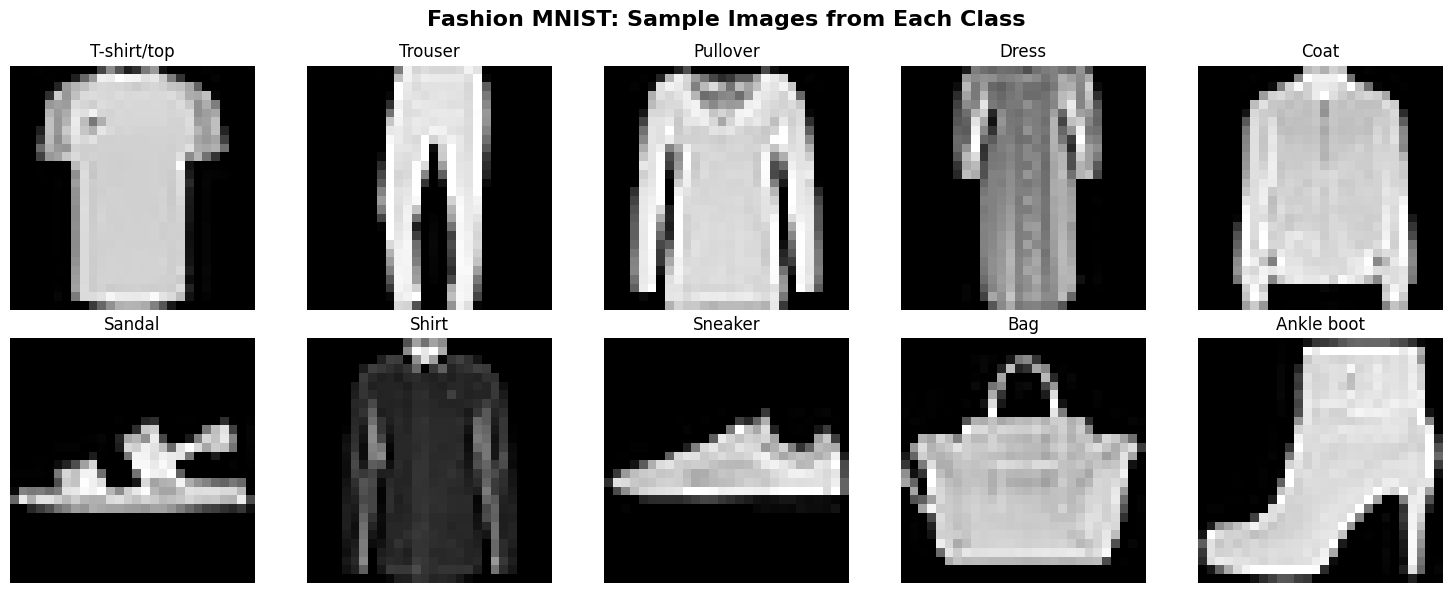

In [3]:
# Visualize random samples from each class

# Pre-compute class indices once
class_indices_dict = {}
for i, item in enumerate(train_data):
    label = item['label']
    if label not in class_indices_dict:
        class_indices_dict[label] = []
    class_indices_dict[label].append(i)

# Now visualize - much faster!
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Fashion MNIST: Sample Images from Each Class', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Get a random image from this class
    random_idx = random.choice(class_indices_dict[idx])
    
    img = train_data[random_idx]['image']
    label = train_data[random_idx]['label']
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{class_names[label]}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

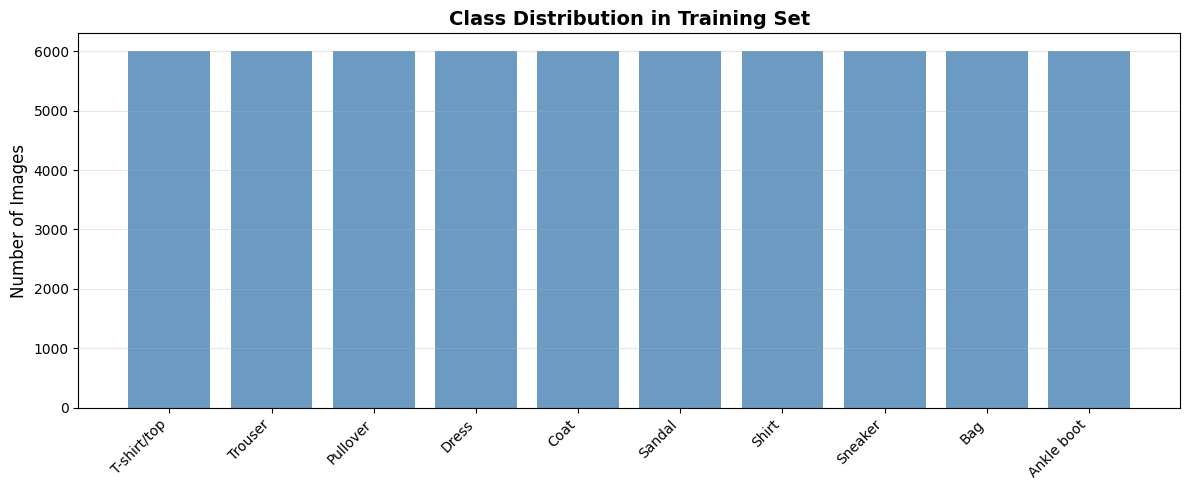


Class distribution:
T-shirt/top    :  6000 images (10.0%)
Trouser        :  6000 images (10.0%)
Pullover       :  6000 images (10.0%)
Dress          :  6000 images (10.0%)
Coat           :  6000 images (10.0%)
Sandal         :  6000 images (10.0%)
Shirt          :  6000 images (10.0%)
Sneaker        :  6000 images (10.0%)
Bag            :  6000 images (10.0%)
Ankle boot     :  6000 images (10.0%)


In [4]:
# Analyze class distribution
from collections import Counter

train_labels = [item['label'] for item in train_data]
label_counts = Counter(train_labels)

# Plot class distribution
plt.figure(figsize=(12, 5))
plt.bar(range(10), [label_counts[i] for i in range(10)], color='steelblue', alpha=0.8)
plt.xticks(range(10), class_names, rotation=45, ha='right')
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for i in range(10):
    print(f"{class_names[i]:15s}: {label_counts[i]:5d} images ({label_counts[i]/len(train_data)*100:.1f}%)")

## 🧠 What are Image Embeddings?

### The Problem
Computers don't "see" images the way humans do. To a computer, an image is just a grid of numbers (pixel values). But then how does it compare images? How does it know if two images are similar?

### The Solution: Embeddings
**Embeddings** are dense numerical representations that capture the *meaning* or *content* of data numerically.

Think of embeddings as a "fingerprint" for each image:
- Similar images (e.g., two sneakers) have similar embeddings
- Different images (e.g., a sneaker and a dress) have different embeddings

### How Do We Get Embeddings?
We use a pre-trained neural network (like DINO) that has learned to extract meaningful features from millions of images. The network converts each image into a fixed-size vector (typically 384, 768, or more dimensions).

### Why DINO?
**DINO** (Self-DIstillation with NO labels) is a state-of-the-art vision transformer model that:
- Learns powerful visual representations without labeled data
- Can identify objects, textures, and semantic relationships
- Works great for transfer learning on various vision tasks

Let's load DINO and see it in action!

In [5]:
# Load DINO model (using the Vision Transformer variant)
# model_name = "facebook/dino-vitb16"  # DINO ViT-Base with 16x16 patches
model_name = "facebook/dinov2-base"  # Using DINOv2 Base

print(f"Loading {model_name}...")
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully!")
print(f"Model output dimension: {model.config.hidden_size}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading facebook/dinov2-base...
Model loaded successfully!
Model output dimension: 768


In [6]:
def extract_embeddings(images, batch_size=32):
    """
    Extract embeddings from a list of PIL images using DINO
    
    Args:
        images: List of PIL Image objects
        batch_size: Number of images to process at once
    
    Returns:
        numpy array of embeddings (num_images, embedding_dim)
    """
    embeddings = []
    
    with torch.no_grad():  # No gradient computation needed
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            
            # Preprocess images
            inputs = image_processor(images=batch, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get model outputs
            outputs = model(**inputs)
            
            # Use the [CLS] token embedding (first token)
            # This represents the entire image
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

print("Embedding extraction function ready!")

Embedding extraction function ready!


In [7]:
# For computational efficiency, let's work with a subset of the data
# You can increase this number if you have more compute power
num_samples = 5000  # Use 5000 samples from training set

print(f"Extracting embeddings for {num_samples} images...")

# Sample random indices
sample_indices = random.sample(range(len(train_data)), num_samples)

# Get images and labels
sample_images = [train_data[idx]['image'].convert('RGB') for idx in sample_indices]
sample_labels = np.array([train_data[idx]['label'] for idx in sample_indices])

# Extract embeddings (this may take a few minutes)
embeddings = extract_embeddings(sample_images, batch_size=32)

print(f"Embeddings extracted!")
print(f"Embedding shape: {embeddings.shape}")
print(f"Each image is now represented as a {embeddings.shape[1]}-dimensional vector")

Extracting embeddings for 5000 images...
Embeddings extracted!
Embedding shape: (5000, 768)
Each image is now represented as a 768-dimensional vector


## 🗺️ Dimensionality Reduction with UMAP

### The Challenge
Our embeddings are high-dimensional (768 dimensions for DINO). Humans can only visualize 2D or 3D space. How do we visualize these embeddings then?

### Enter UMAP
**UMAP** (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that:
- Reduces high-dimensional data to 2D or 3D
- Preserves both **local** and **global** structure
- Keeps similar items close together
- Is faster than t-SNE for large datasets

### How Does Clustering Work?
When we reduce embeddings to 2D using UMAP, similar images naturally cluster together because:
1. The neural network learned to create similar embeddings for similar images
2. UMAP preserves these similarities when projecting to 2D
3. Items from the same class (e.g., all sneakers) end up in the same region

Let's see the magic happen!

In [8]:
# Apply UMAP to reduce embeddings from 768D to 2D
print("Applying UMAP dimensionality reduction...")
print("This may take a few minutes...")

umap_reducer = UMAP(
    n_components=2,        # Reduce to 2D
    n_neighbors=15,        # Balance between local and global structure
    min_dist=0.1,          # Minimum distance between points
    metric='cosine',       # Cosine similarity works well for embeddings
    random_state=42
)

# Fit and transform the embeddings
embeddings_2d = umap_reducer.fit_transform(embeddings)

print(f"UMAP complete!")
print(f"Reduced shape: {embeddings_2d.shape}")
print(f"Original {embeddings.shape[1]}D embeddings → {embeddings_2d.shape[1]}D for visualization")

Applying UMAP dimensionality reduction...
This may take a few minutes...


/storage/home/hcoda1/5/rmehta307/scratch/fall-2025-interest-group-projects/user/ritesh/cv/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP complete!
Reduced shape: (5000, 2)
Original 768D embeddings → 2D for visualization


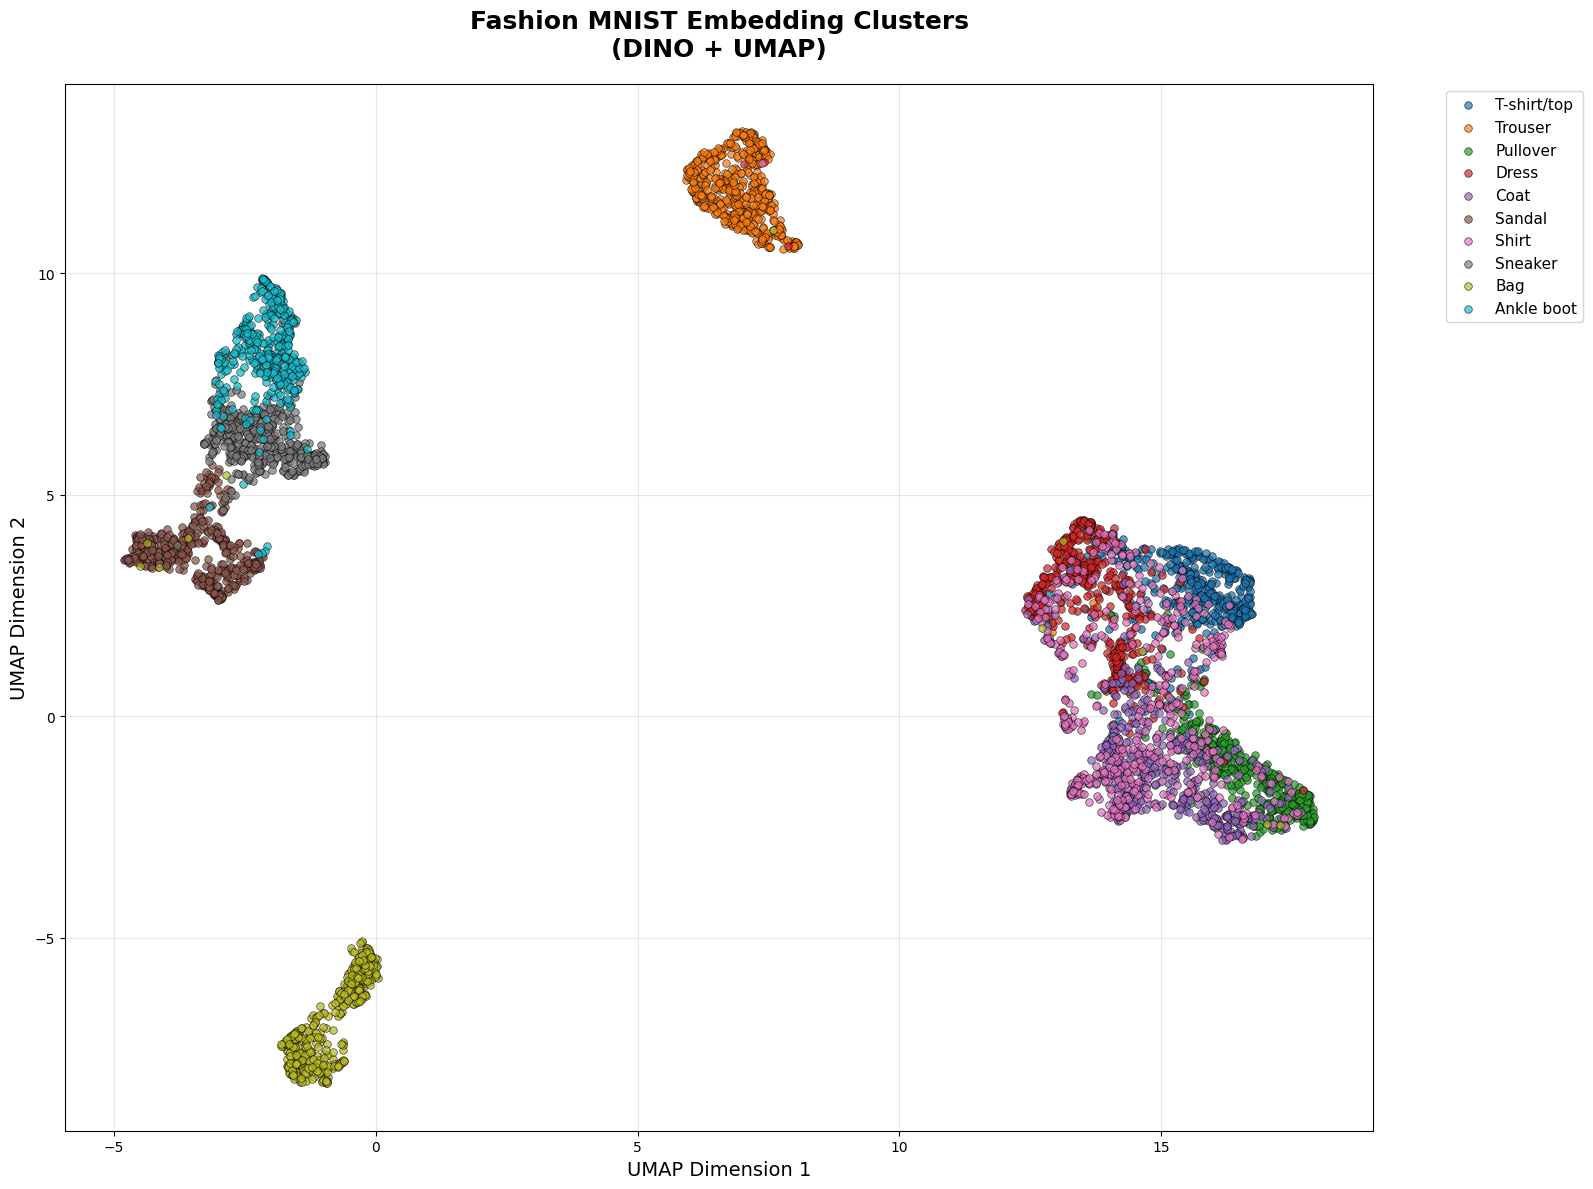

In [9]:
# Create visualization of clusters
fig, ax = plt.subplots(figsize=(16, 12))

# Create a color for each class
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot all points in light gray first
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='lightgray', alpha=0.3, s=10)

# Overlay colored points by class
for class_id in range(10):
    mask = sample_labels == class_id
    ax.scatter(
        embeddings_2d[mask, 0], 
        embeddings_2d[mask, 1],
        c=[colors[class_id]],
        label=class_names[class_id],
        alpha=0.7,
        s=30,
        edgecolors='black',
        linewidths=0.5
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
ax.set_title('Fashion MNIST Embedding Clusters\n(DINO + UMAP)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# After UMAP, check cluster quality
from sklearn.metrics import silhouette_score

# Silhouette score: how well-separated the clusters are
score = silhouette_score(embeddings_2d, sample_labels, metric='euclidean')
print(f"Silhouette Score: {score:.3f}")
print("(Higher is better, range: -1 to 1)")

Silhouette Score: 0.368
(Higher is better, range: -1 to 1)


## 📊 Understanding Silhouette Score

### What Does It Measure?

The Silhouette Score evaluates **cluster quality** by measuring:
- **Cohesion**: How close points are to others in their cluster
- **Separation**: How far points are from other clusters

### The Math (Simplified)

For each point, we calculate:

**Silhouette = (separation - cohesion) / max(separation, cohesion)**

### Interpretation Guide

| Score | Cluster Quality | What It Means |
|-------|----------------|---------------|
| **0.71 - 1.00** | Excellent | Strong, distinct clusters with clear boundaries |
| **0.51 - 0.70** | Good | Well-formed clusters with some overlap |
| **0.26 - 0.50** | Fair | Weak structure, significant overlap |
| **0.00 - 0.25** | Poor | Barely distinguishable clusters |
| **< 0.00** | Bad | Points assigned to wrong clusters |

### For Our Fashion MNIST Results

A score around **0.3-0.5** is typical because:
- Some classes are very distinct (Sneakers vs Bags)
- Some classes overlap (T-shirts vs Shirts, Pullover vs Coat)
- This reflects real-world similarity in fashion items!

Query image class: Ankle boot


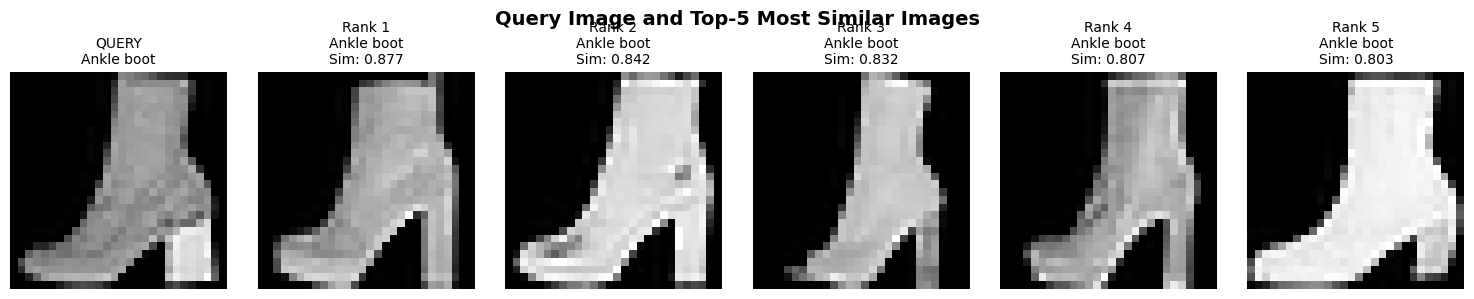

In [11]:
# Let's find nearest neighbors in embedding space
from sklearn.neighbors import NearestNeighbors

# Build nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(embeddings)

def visualize_similar_images(query_idx, k=6):
    """
    Visualize k most similar images to a query image
    """
    # Find nearest neighbors
    distances, indices = nn_model.kneighbors([embeddings[query_idx]], n_neighbors=k)
    
    # Plot results
    fig, axes = plt.subplots(1, k, figsize=(15, 3))
    fig.suptitle(f'Query Image and Top-{k-1} Most Similar Images', 
                 fontsize=14, fontweight='bold')
    
    for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
        ax = axes[i]
        img = sample_images[idx]
        label = sample_labels[idx]
        
        ax.imshow(img)
        title = f"{'QUERY' if i == 0 else f'Rank {i}'}\n{class_names[label]}"
        if i > 0:
            title += f"\nSim: {1-dist:.3f}"
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test with a random image
test_idx = random.randint(0, len(sample_images)-1)
print(f"Query image class: {class_names[sample_labels[test_idx]]}")
visualize_similar_images(test_idx, k=6)

Finding images similar to a Sneaker...


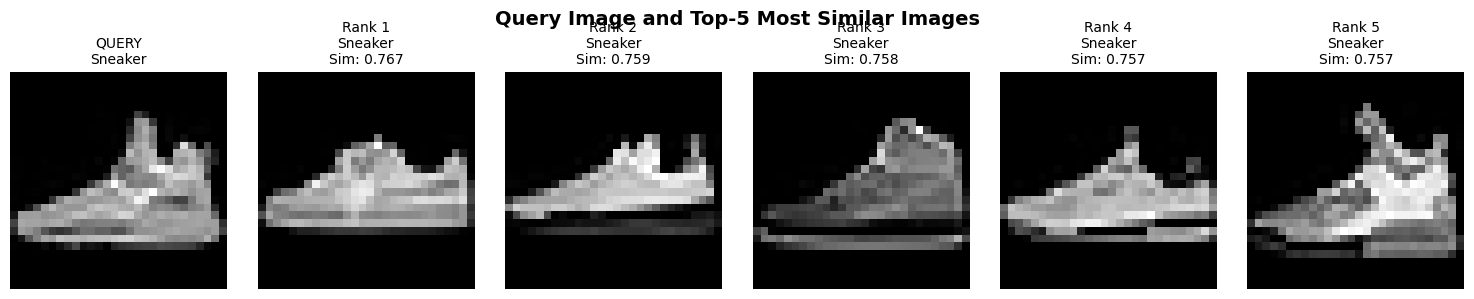

In [12]:
# Interactive: Try different query images
# Change the class name to explore different clothing items

def find_and_visualize_class(class_name):
    """
    Find random image from a class and show similar images
    """
    # Get class id
    class_id = class_names.index(class_name)
    
    # Find images of this class in our sample
    class_indices = np.where(sample_labels == class_id)[0]
    
    if len(class_indices) == 0:
        print(f"No {class_name} found in sample!")
        return
    
    # Pick random image
    query_idx = random.choice(class_indices)
    
    print(f"Finding images similar to a {class_name}...")
    visualize_similar_images(query_idx, k=6)

# Try it out! Change the class name below:
find_and_visualize_class('Sneaker')

## 🎓 Key Takeaways

### What We Learned:

1. **Embeddings are Powerful Representations**
   - Neural networks convert images into meaningful numerical vectors
   - Similar images have similar embeddings (measured by cosine similarity or distance)
   - These embeddings capture semantic meaning, not just pixel values

2. **Clustering Happens Naturally**
   - Without any explicit training to cluster, similar items group together
   - This is because the model learned general visual features from millions of images
   - Different clothing types occupy different regions in embedding space

3. **Dimensionality Reduction Enables Visualization**
   - UMAP helps us "see" high-dimensional data in 2D
   - Clusters that exist in 768D also appear in 2D (though some information is lost)
   - This visualization helps us understand what the model has learned

### Real-World Applications:

- **Image Search**: Find similar images to a query image
- **Recommendation Systems**: Suggest similar products
- **Anomaly Detection**: Find unusual or outlier images
- **Data Organization**: Automatically categorize large image collections
- **Transfer Learning**: Use these embeddings as features for other tasks

### Try These Extensions:

1. Experiment with different DINO models (ViT-Small, ViT-Base, ViT-Large)
2. Try different UMAP parameters (n_neighbors, min_dist)
3. Use PCA instead of UMAP and compare results
4. Build a simple image search engine using these embeddings
5. Apply this to a different dataset (CIFAR-10, your own images!)

Great job completing this tutorial! 🎉